<a href="https://colab.research.google.com/github/xslittlemaggie/Tencent_Education_Deep_Learning_Course/blob/master/bikes_prediction_Time_Series_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [0]:
import pandas as pd
import numpy as np
import time
# visualization
import matplotlib.pyplot as plt

# model building
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM

In [0]:
data = pd.read_csv("http://resuly.me/data/bike_rnn.csv")

In [83]:
data.head(10)

,num,weekday,hour
0,0,5,17
1,1,5,17
2,1,5,17
3,2,5,17
4,4,5,17
5,5,5,17
6,5,5,17
7,5,5,17
8,4,5,17
9,3,5,17


### 特征变量：
- num: 自行车数量
- weekday: 星期
- hour: 小时

总共**45949** 条数据

这些数据是按照一分钟一分钟的顺序排列的。

就是用前面的时间的车的数量，预测后面一分钟车的数量
例如， 用前面9分钟的车的数量，预测第十分钟会有多少量车

## 数据预处理

In [0]:
sequence_length = 100

result = []
for index in range(len(data) - sequence_length):
  result.append(data["num"][index: index + sequence_length])
result = np.array(result).astype("float64")

如果数据预处理过的话，训练效果往往更好 (cf Y. Lecun’s 1995 paper, section 4.3)。而且就时间序列的数据类型而言，我们并不希望处理后的数据和真实数据偏差非常大，所以本文用了一直非常简单的方法进行数据的预处理工作。首先计算整个数据的平均值，然后把每个原始数据都减去这个均指，这样数据整体的变化就在0上下波动。

In [85]:
result -= result.mean()
print("Shift: ", result.mean())
print("Data: ", result.shape)

Shift:  -8.335844561839393e-15
Data:  (45849, 100)


In [86]:
result

array([[-7.00284434, -6.00284434, -6.00284434, ..., -7.00284434,
        -6.00284434, -7.00284434],
       [-6.00284434, -6.00284434, -5.00284434, ..., -6.00284434,
        -7.00284434, -7.00284434],
       [-6.00284434, -5.00284434, -3.00284434, ..., -7.00284434,
        -7.00284434, -7.00284434],
       ...,
       [-1.00284434, -1.00284434, -1.00284434, ..., -1.00284434,
        -1.00284434, -1.00284434],
       [-1.00284434, -1.00284434, -1.00284434, ..., -1.00284434,
        -1.00284434, -1.00284434],
       [-1.00284434, -1.00284434, -2.00284434, ..., -1.00284434,
        -1.00284434, -1.00284434]])

In [0]:
row = int(round(0.9 * result.shape[0]))
train = result[:row, :]
np.random.shuffle(train)
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = result[row:, :-1]
y_test = result[row:, -1]

下一步操作是把数据分为训练集和测试集，输入和输出。我们选了10%的数据作为测试，90%的数据进行训练。每个20长度的序列的最后一个值作为目标值，其余前面的部分作为输入值。输入值输入到模型，目标值是真实值，也就是模型想要达到的目标。

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [89]:
print("X_train: ", X_train.shape)
print("Y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("Y_test: ", y_test.shape)

X_train:  (41264, 99, 1)
Y_train:  (41264,)
X_test:  (4585, 99, 1)
Y_test:  (4585,)


## 建模

layers: 我们的网络有1维的数值输入，两个隐含层（两层LSTM）的输出结果的数量分别为50和100，最后一层（output layer）的输出层维度为1，代表着预测结果。

In [117]:
from keras.layers import SimpleRNN
model = Sequential()
layers = [1, 50, 100, 1]
# 第一层
model.add(SimpleRNN(
        layers[1], # 我们输入的是一维的，所以定义输入的维度为1
        input_shape = (None, 1), # 这一层的输出数量
        return_sequences = True))
model.add(Dropout(0.2))

# 第二层，直接填写我们期望的输出数量 (layers[2])就可以了，Keras会自动处理上一层输入操作等等。
model.add(SimpleRNN(
       layers[2],
       return_sequences = False)) # 主要是多对一的关系，一般是最后一层
model.add(Dropout(0.2))

# 第三层， 最后一层用Dense,也就是上一层的输出结果全部都乘以一个举证，最终得到一个数。由于这里是进行线性回归操作，所以激活函数填linera
model.add(Dense(
        layers[3] # 期望的输出个数是layers[3]
        ))
model.add(Activation("linear"))

start = time.time()
model.compile(loss = "mse", optimizer = "rmsprop")  # rmsprop 线性回归问题的标准做法
print("Compilation Time:", time.time() - start)

Compilation Time: 0.024069786071777344


In [0]:
from keras.layers import SimpleRNN
model = Sequential()

# 第一层
model.add(SimpleRNN(
        3, # 我们输入的是一维的，所以定义输入的维度为1
        input_shape = (None, 2), # 这一层的输出数量
        return_sequences = True))

model.compile(loss = "mse", optimizer = "rmsprop")  # rmsprop 线性回归问题的标准做法


In [205]:
X = np.array([[[1,2]]])
model.predict(X)

array([[[ 0.21000788,  0.4139978 , -0.07787   ]]], dtype=float32)

In [206]:
# W
model.get_weights()[0].shape


(2, 3)

In [207]:
# U
model.get_weights()[1]

array([[-0.47977915, -0.65861034, -0.5796934 ],
       [ 0.8762134 , -0.32546702, -0.3554172 ],
       [ 0.04541037, -0.67845684,  0.7332355 ]], dtype=float32)

In [208]:
# bias
model.get_weights()[2]

array([0., 0., 0.], dtype=float32)

In [0]:
W = model.get_weights()[0]
U = model.get_weights()[1]
b = model.get_weights()[2]

def myRNN(n,X, W, U, b):
  "return Y"
  h = [[0], [0], [0]]
  Y = U * h + W * X + b
  return Y
  

In [0]:
h = np.array([[0], [0], [0]])
state = U.dot(h)

In [0]:
#W.dot(X)
X_ = X.reshape(X.shape[-1], 1)
prod = W.T.dot(X_)

In [0]:
b = model.get_weights()[2]

In [216]:
Y = state + prod 

np.tanh(Y)

array([[ 0.21000788],
       [ 0.41399778],
       [-0.07786999]])

In [185]:
myRNN(3,X, W, U, b)

ValueError: ignored

首先从Keras创立一个 Sequential 对象，这代表我们将在这个Sequential 对象的基础上一层一层堆叠我们的模型。 layers 记录着四个数字，代表着每一层的大小。

我们的网络有1维的数值输入，两个隐含层（两层LSTM）的输出结果的数量分别为50和100，最后一层（output layer）的输出层维度为1，代表着预测结果[]。

### Return_Sequence

## 模型训练

In [91]:
history = model.fit(X_train, y_train,
         batch_size = 512, 
         epochs = 20, 
         validation_split = 0.05)

Train on 39200 samples, validate on 2064 samples
Epoch 1/20
39200/39200 [==============================] - 27s 680us/step - loss: 8.6911 - val_loss: 3.1070
Epoch 2/20
39200/39200 [==============================] - 25s 637us/step - loss: 2.3811 - val_loss: 2.2290
Epoch 3/20
39200/39200 [==============================] - 25s 639us/step - loss: 1.8222 - val_loss: 1.7032
Epoch 4/20
39200/39200 [==============================] - 25s 627us/step - loss: 1.5663 - val_loss: 1.5314
Epoch 5/20
39200/39200 [==============================] - 25s 646us/step - loss: 1.4421 - val_loss: 1.7275
Epoch 6/20
39200/39200 [==============================] - 25s 630us/step - loss: 1.3947 - val_loss: 1.4863
Epoch 7/20
39200/39200 [==============================] - 25s 646us/step - loss: 1.3459 - val_loss: 1.4762
Epoch 8/20
39200/39200 [==============================] - 26s 652us/step - loss: 1.3095 - val_loss: 1.5084
Epoch 9/20
39200/39200 [==============================] - 25s 648us/step - loss: 1.3066 - val_l

In [0]:
y_predicted = model.predict(X_test)
y_predicted = np.reshape(y_predicted, (y_predicted.size, ))

## Visualization

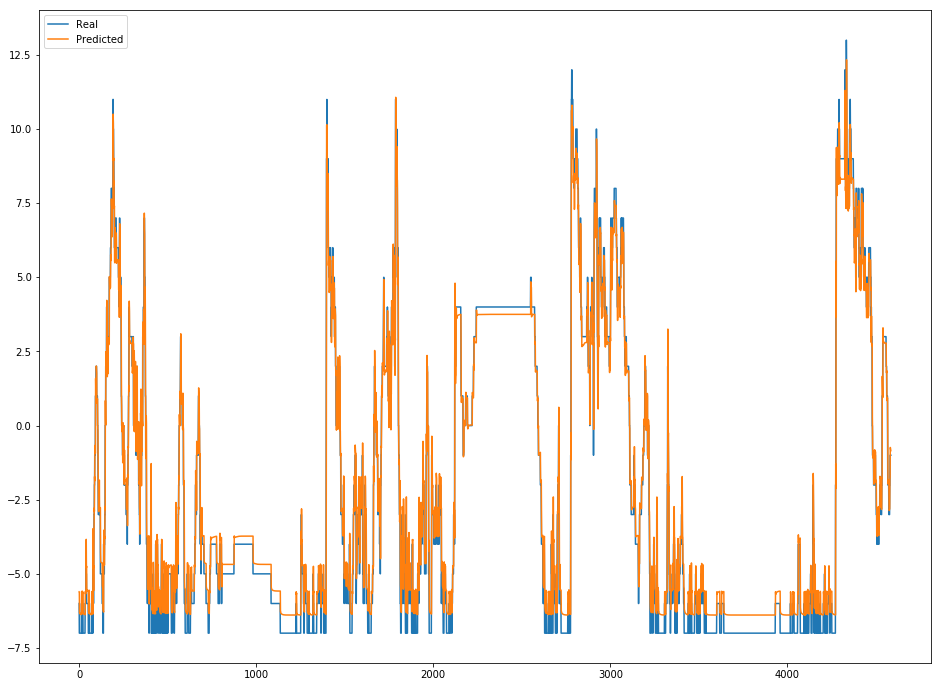

In [93]:
plt.figure(figsize = (16, 12))
plt.plot(y_test)
plt.plot(y_predicted)
plt.legend(["Real", "Predicted"])
plt.show()

In [94]:
y_predicted[:19]

array([-5.608796 , -5.613207 , -6.3138256, -6.306411 , -6.341939 ,
       -6.347187 , -6.358446 , -6.3623123, -6.366338 , -6.369052 ,
       -6.3716145, -6.373829 , -6.3758698, -6.3777075, -5.595709 ,
       -5.6808023, -6.3572187, -6.339344 , -5.586111 ], dtype=float32)

## self prediction

In [0]:
sequence_length = 99
auto_predict = [x for x in y_predicted]
for i in range(1000):
  temp = y_predicted[-99:]
  #print(temp)
  temp = np.reshape(temp, (1, 99, 1))
  res = model.predict(temp)
  auto_predict.append(res[0][0])
#auto_predict

In [0]:
auto_predicted = np.array(auto_predict)
auto_predicted = np.reshape(auto_predicted, (auto_predicted.size, ))

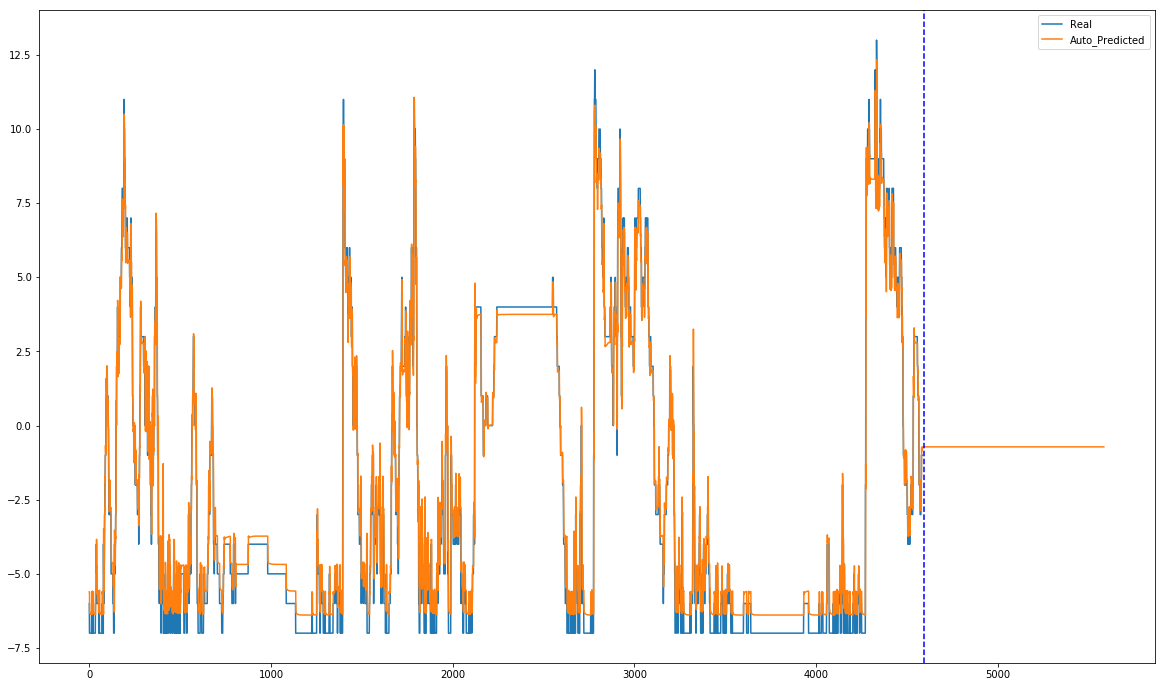

In [97]:
plt.figure(figsize = (20, 12))
plt.plot(y_test)
#plt.plot(y_predicted)
plt.plot(auto_predicted)
plt.legend(["Real", "Auto_Predicted"])
plt.axvline(x=4593, color='blue', linestyle='--')
plt.show()